# Questions:
- How large are the 4 research groups in the LSE Maths Deparment?
- Who are the influential professors?
- Are certain groups more collaborative than others?
- How collaborative are professors between departments?

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from netgraph import Graph
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
# Define the LSE colour
LSE_RED = '#ed1c2e'

### Define the URLs of the pages we will be scraping

In [3]:
dma_url = "https://www.lse.ac.uk/Mathematics/Research/Discrete-Mathematics-and-Algorithms"
fin_url = "https://www.lse.ac.uk/Mathematics/Research/Financial-Mathematics-and-Control-Theory"
game_url = "https://www.lse.ac.uk/Mathematics/Research/Game-Theory"
or_url = "https://www.lse.ac.uk/Mathematics/Research/Operations-Research"

### Create a function to help us scrape a url and return a list of professors
* `DMA` : Discrete Maths and Algorithms
* `FIN` : Financial Maths
* `GAME` : Game Theory
* `OR` : Operational Research

In [4]:
def get_professors(url):
    
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'lxml')
    div = soup.find('div', class_ = "pageContent pageContent--std")
    # Find all headers
    profs = div.find_all('a')
    #return profs
    
    # Extract the text from each header
    profs = [prof.text for prof in profs]
    #return profs
    # Remove the `\xa0` unicode
    profs = [prof.replace('\xa0', ' ') for prof in profs]
    
    # Remove whitespace
    profs = [prof.strip() for prof in profs]
    
    return profs

### Create the 4 lists of professors

In [5]:
dma_profs = get_professors(dma_url)
fin_profs = get_professors(fin_url)
game_profs = get_professors(game_url)
or_profs = get_professors(or_url)

or_profs

['Dr Ahmad Abdi',
 '',
 'Dr Grammateia Kotsialou',
 'Dr Neil Olver',
 'Dr Katerina Papadaki',
 'Professor Gregory Sorki',
 'Professor László Végh',
 'Dr Aled Williams',
 'Dr Giacomo Zambelli',
 'Postdocs',
 'Dr Franziska Eberle',
 'Dr Christoph Hertrich',
 'Dr Sharat Ibrahimpur',
 'Research Students',
 'Karl Stickler',
 'Rulian Wang']

### The lists still require some cleaning

In [6]:
# Clean DMA list
dma_profs.pop(5)
dma_profs = dma_profs[:-8]

In [7]:
# Clean FIN list
fin_profs.pop(0)
fin_profs = fin_profs[:-9]
fin_profs.pop(3)

''

In [8]:
# Clean GAME list
game_profs.pop(2)
game_profs.pop(3)
game_profs.pop(4)
game_profs = game_profs[:-5]

In [9]:
# Clean OR list
or_profs.pop(1)
or_profs = or_profs[:-7]

### Visualise Research Group sizes
- We can use the Plotly Express package to make it interactive

In [10]:
size_dict = {'DMA' : [len(dma_profs)],
             'FIN' : [len(fin_profs)],
             'GAME' : [len(game_profs)],
             'OR' : [len(or_profs)],
}

group_size_df = pd.DataFrame(size_dict)

### Unfortunately, the plot does not render well in the pdf version due to its size. However, it looks fine in the notebook.

In [11]:
melted_df = pd.melt(group_size_df, var_name='Research Group', value_name='Count')

# create the bar plot
fig = px.bar(melted_df, x='Research Group', y='Count', color='Research Group',
             title = "Size of each group", color_discrete_sequence=[LSE_RED, 'gold', 'purple', 'black'],
            range_y = (2,12))
fig.show()

## We will use a new package, `netgraph`, to show the different clusters
* We will use Netgraph for the visualisation as it looks slighlty nicer than NetworkX
* But we will use NetworkX to calculate metrics about the networks

In [12]:
# Create a list of the 4 areas
areas = ["DMA", "FIN", "OR", "GAME"]

In [13]:
# Create the first layer of the graph
area_edges = [("Maths", area) for area in areas]

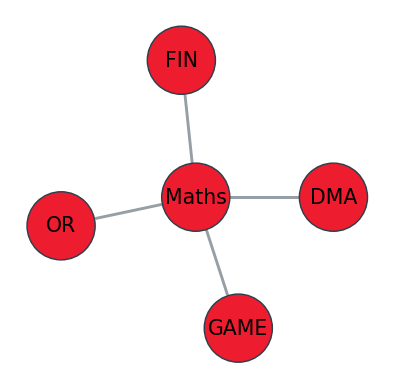

In [14]:
# Initial layout
Graph(area_edges, node_layout='radial', node_size = 12, node_color = LSE_RED, node_labels = True);

### A function to create the edges 

In [15]:
def edges(area, profs):
    edges = [(area, prof) for prof in profs]
    
    return edges

In [16]:
all_profs = dma_profs + fin_profs + game_profs + or_profs

### A bit of cleaning

In [17]:
# Check for duplicates (it will make the visualisation look bad)
pd.Series(all_profs).value_counts()

Professor Andrew Lewis-Pye        2
Dr Robert Simon                   2
Dr Aled Williams                  1
Professor Peter Allen             1
Dr Arne Lokka                     1
Professor Gregory Sorki           1
Dr Emilio Pierro                  1
Professor Konrad Swanepoel        1
Professor Amol Sasane             1
Professor Olivier Gossner         1
Dr Galit Ashkenazi-Golan          1
Professor Martin Anthony          1
Professor Jozef Skokan            1
Dr Ahmad Abdi                     1
Professor Graham Brightwell       1
Dr Grammateia Kotsialou           1
Dr Tugkan Batu                    1
Dr Giacomo Zambelli               1
Professor Luitgard Veraart        1
Dr Neil Olver                     1
Dr Pavel Gapeev                   1
Professor Bernhard von Stengel    1
Professor Julia Böttcher          1
Dr Albina Danilova                1
Professor Johannes Ruf            1
Dr Katerina Papadaki              1
Professor Mihail Zervos           1
Dr Christoph Czichowsky     

In [18]:
# Find what areas the dulicates are in
("Dr Robert Simon" in dma_profs, "Dr Robert Simon" in fin_profs, \
"Dr Robert Simon" in game_profs, "Dr Robert Simon" in or_profs)

(True, False, True, False)

In [19]:
# Find what areas the dulicates are in
("Professor Andrew Lewis-Pye" in dma_profs, "Professor Andrew Lewis-Pye" in fin_profs, \
"Professor Andrew Lewis-Pye" in game_profs, "Professor Andrew Lewis-Pye" in or_profs)

(True, False, True, False)

In [20]:
# Remove them from the longer DMA list
dma_profs.remove("Dr Robert Simon")
dma_profs.remove("Professor Andrew Lewis-Pye")

### Create a list with all the edges to professors

In [21]:
#Create the list of all edges in the graph
prof_edges = edges("DMA", dma_profs) + edges("GAME", game_profs) + \
            edges("FIN", fin_profs) + edges("OR", or_profs)

In [22]:
# Create a list with all edges
all_edges = area_edges + prof_edges

In [23]:
# Colouring the edges
area_colour = {area : 'black' for area in area_edges}
dma_colour = {dma_prof : 'purple' for dma_prof in edges("DMA", dma_profs)}
fin_colour = {fin_prof : 'green' for fin_prof in edges("GAME", game_profs)}
game_colour = {game_prof : 'blue' for game_prof in edges("FIN", fin_profs)}
or_colour = {or_prof : 'gold' for or_prof in edges("OR", or_profs)}
colouring = area_colour | dma_colour | fin_colour | game_colour | or_colour

### Final graph layout

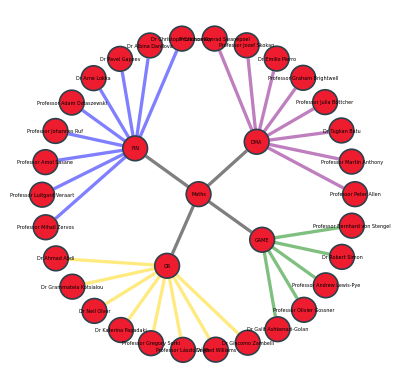

In [24]:
Graph(all_edges, node_layout='radial', node_size = 4, \
      edge_color = colouring, node_label_fontdict=dict(size=3.5), \
      node_color = LSE_RED, node_labels = True);

### Collect the data for interests of professors
* We create a list of lists, where each sub-list has the interests of a professor

In [25]:
def prof_interests(url):

    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'lxml')
    div = soup.find_all('div', class_ = "accordion__txt")
    # Clean the data
    interests = [prof_interests.text for prof_interests in div]
    interests = [prof_interests[1:-2] for prof_interests in interests]
    interests = [prof_interests.replace('\n', '.') for prof_interests in interests]
    interests = [prof_interests.split('.') for prof_interests in interests]
    return interests

In [26]:
for interests in prof_interests(fin_url)[:3]:
    print(interests)

['Financial mathematics; stochastic optimal control; stochastic analysis; optimal portfolio choice; market frictions; transaction costs; shadow prices; duality; mean-variance portfolio optimisation', '']
['Financial mathematics; derivative pricing and hedging in incomplete markets and/or under asymmetric information;\xa0 stochastic calculus; stochastic control and optimisation; insider trading; utility maximisation and equilibrium theor']
['Stochastic calculus; optimal stopping and free-boundary problems; pricing of American options; sequential testing and disorder detection problems; interest rate and credit risk models; illiquidity markets; stochastic impulse control and optimisation; Gaussian processes', '']


### NLP to tokenise the words
- This will let us stem words. For example, we want to interpret "algorithms" and "algorithmic" as the same word.

In [27]:
import nltk
nltk.download('punkt')

# define a function to tokenize a list of strings
def tokenize(text):
    tokens = []
    for sentence in text:
        tokens.extend(nltk.word_tokenize(sentence.lower()))
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bbste\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
# tokenize each sublist in the main list, for each department
tokenized_dma_interests = [tokenize(sublist) for sublist in prof_interests(dma_url)]
tokenized_fin_interests = [tokenize(sublist) for sublist in prof_interests(fin_url)]
tokenized_game_interests = [tokenize(sublist) for sublist in prof_interests(game_url)]
tokenized_or_interests = [tokenize(sublist) for sublist in prof_interests(or_url)]

### Convert the tokenised interests into their stems, and clean the data to keep essential words

In [29]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')


def clean_text(text):
    stemmer = PorterStemmer()
    cleaned_text = []
    for words in text:
        # Tokenize words in each sublist
        words = nltk.word_tokenize(' '.join(words))
        # Remove stop words
        words = [word for word in words if word.lower() not in stopwords.words('english')]
        # Perform stemming
        words = [stemmer.stem(word) for word in words]
        # Remove non-alphabetic characters
        words = [word for word in words if word.isalpha()]
        cleaned_text.append(words)
    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bbste\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Lists of our stemmed words
stems_interests_dma = clean_text(tokenized_dma_interests)
stems_interests_fin = clean_text(tokenized_fin_interests)
stems_interests_game = clean_text(tokenized_game_interests)
stems_interests_or = clean_text(tokenized_or_interests)

In [31]:
stems_interests_fin[0]

['financi',
 'mathemat',
 'stochast',
 'optim',
 'control',
 'stochast',
 'analysi',
 'optim',
 'portfolio',
 'choic',
 'market',
 'friction',
 'transact',
 'cost',
 'shadow',
 'price',
 'dualiti',
 'portfolio',
 'optimis']

## We now reduce the number of words being considered.
* For example, we remove the stem of "financial" for professor in the financial maths group beause it appears for all of them.

In [32]:
# Remove duplicate words in a professor's research areas, and non essential words
for i in range(len(stems_interests_dma)):
    stems_interests_dma[i] = list(set(stems_interests_dma[i]))
    
for i in range(len(stems_interests_fin)):
    stems_interests_fin[i] = list(set(stems_interests_fin[i]))
    
for i in range(len(stems_interests_game)):
    stems_interests_game[i] = list(set(stems_interests_game[i]))

for i in range(len(stems_interests_or)):
    stems_interests_or[i] = list(set(stems_interests_or[i]))

In [33]:
# Iterate through all sublists for dma department, remove non-essential words

words_to_remove = ['graph', 'algorithm', 'extrem', 'theori', 'model', 'mathemat', 'learn', 'problem',\
                   'comput', 'test', 'properti', 'data', 'structur', 'method', 'aspect', 'finit', 'applic',\
                   'assign', 'scienc', 'simpl', 'analysi', 'function', 'game', 'method', 'comput']

stems_interests_dma = [[word for word in sublist if word not in words_to_remove] for sublist in stems_interests_dma]

In [34]:
# Iterate through all sublists for fin department, remove non-essential words

words_to_remove = ['market', 'mathemat', 'analysi', 'choic', 'cost', 'financi', \
                   'financ', 'comput', 'problem', 'learn', 'portfolio',\
                   'optimis', 'optim', 'stochast']

stems_interests_fin = [[word for word in sublist if word not in words_to_remove] for sublist in stems_interests_fin]

In [35]:
# Iterate through all sublists for game department, remove non-essential words

words_to_remove = ['inform', 'game', 'theori', 'mathemat', 'analysi', 'theor']

stems_interests_game = [[word for word in sublist if word not in words_to_remove] for sublist in stems_interests_game]

In [36]:
# Iterate through all sublists for or department, remove non-essential words
words_to_remove = ['inform', 'game', 'theori', 'mathemat', 'algorithm', 'analysi', \
                   'optimis', 'theor', 'combinatori']
stems_interests_or = [[word for word in sublist if word not in words_to_remove] for sublist in stems_interests_or]

## NetworkX Visualisation of each research area
- We can now create the plots

In [37]:
def research_area_graph(prof_list, stems_interests):
    interest_sets = [set(stems_interests[i]) for i in range(len(stems_interests))]
    prof_indices = [i for i in range(len(prof_list))]
    
    Graph = nx.Graph()
    
    for pair in list(combinations(prof_indices, 2)):
        if interest_sets[pair[0]].intersection(interest_sets[pair[1]]) != set():
            Graph.add_edge(prof_list[pair[0]], prof_list[pair[1]])
            
    return Graph

### Subplots of the four areas

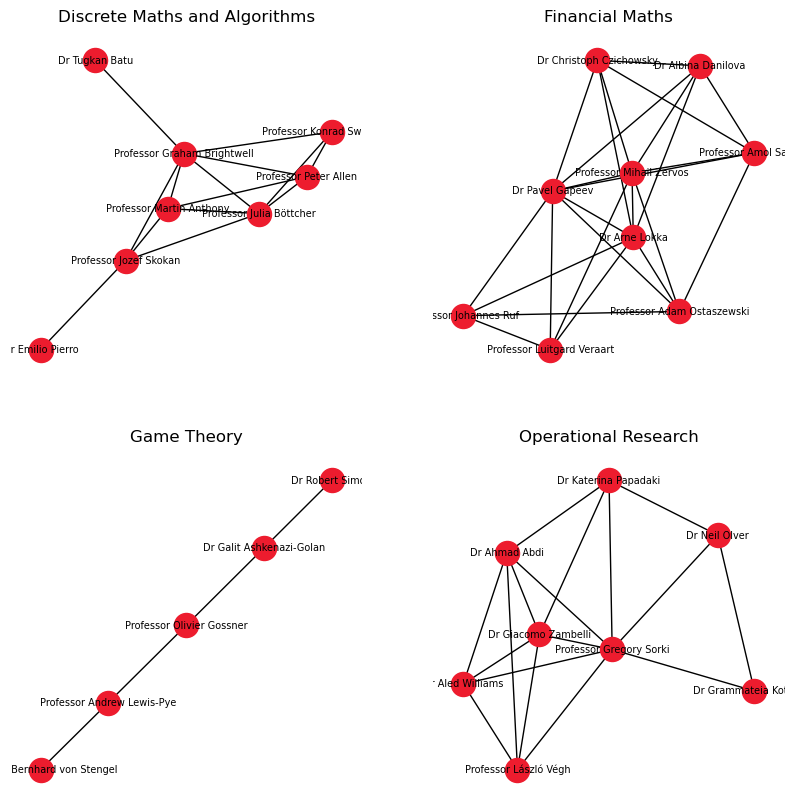

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Draw each graph on a separate subplot
nx.draw(research_area_graph(dma_profs, stems_interests_dma), font_size=7, node_color=LSE_RED, with_labels=True, ax=ax[0, 0])
nx.draw(research_area_graph(fin_profs, stems_interests_fin), font_size=7, node_color=LSE_RED, with_labels=True, ax=ax[0, 1])
nx.draw(research_area_graph(game_profs, stems_interests_game), font_size=7, node_color=LSE_RED, with_labels=True, ax=ax[1, 0])
nx.draw(research_area_graph(or_profs, stems_interests_or), font_size=7, node_color=LSE_RED, with_labels=True, ax=ax[1, 1])

# Set titles
ax[0, 0].set_title('Discrete Maths and Algorithms')
ax[0, 1].set_title('Financial Maths')
ax[1, 0].set_title('Game Theory')
ax[1, 1].set_title('Operational Research')

# Show the plot
plt.show()

### We see that DMA, FIN, and OR are pretty connected even after the remval of words. However, the Game Theory group has pretty low collaboration-potential.

## The entire network

In [39]:
all_stems_interests = stems_interests_dma + stems_interests_fin + stems_interests_game + stems_interests_or

In [40]:
all_profs_graph = research_area_graph(all_profs, all_stems_interests)

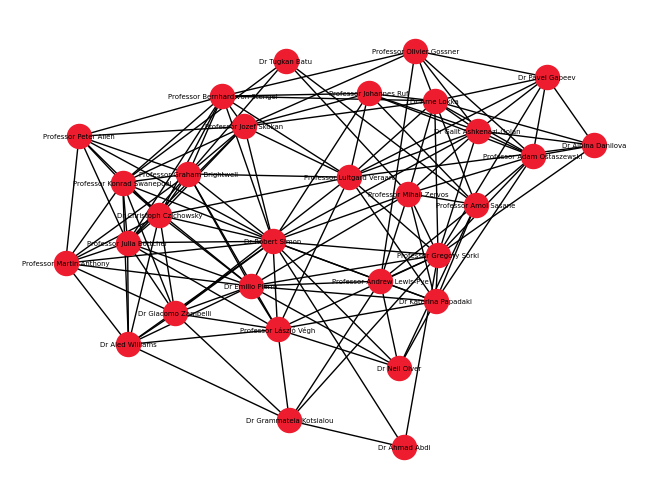

In [41]:
nx.draw(all_profs_graph, font_size=5, node_color=LSE_RED, with_labels=True)

### We see that the different groups connect quite well and that most professors have at least one edge to a professor in a different group.

### Analysis of the whole graph
* We now explore metrics of the large graph, such as node degree and centrality.

In [42]:
# Fix the graph layout
pos=nx.spring_layout(all_profs_graph)

## 1) Degree distribution

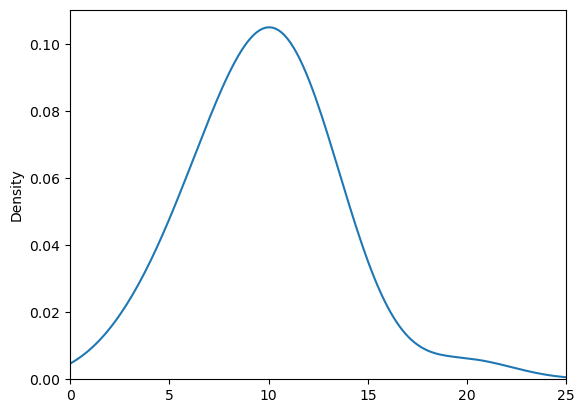

In [43]:
# Degree distribution using a KDE plot
degree = [d for n, d in all_profs_graph.degree()]
sns.kdeplot(degree, bw_method = 0.7);
plt.xlim(0,25);

### 2) Average node degree by research group
- We will create an interactive bar plot.

In [44]:
# Dictionary of professor and group
prof_group_dict = {}

for prof in dma_profs:
    prof_group_dict.update({prof:"DMA"})
for prof in fin_profs:
    prof_group_dict.update({prof:"FIN"})
for prof in game_profs:
    prof_group_dict.update({prof:"GAME"})
for prof in or_profs:
    prof_group_dict.update({prof:"OR"})

In [45]:
# List of tuples 
degree = [(d,n) for n, d in all_profs_graph.degree()]
degree_and_group = [(d,n,prof_group_dict.get(n)) for d,n in degree]

In [46]:
# A function that calulates the average node degree of a group
def average_group_degree(tuples, group):
    
    total_degree = 0
    count = 0
    for tuple in tuples:
        if tuple[2] == group:
            total_degree += tuple[0]
            count += 1
    avg_degree = total_degree/count
    
    return avg_degree

In [47]:
# Create a Dataframe to help us with the plotting
avg_degree_dict = {'DMA_avg' : [average_group_degree(degree_and_group, "DMA")],
             'FIN_avg' : [average_group_degree(degree_and_group, "FIN")],
             'GAME_avg' : [average_group_degree(degree_and_group, "GAME")],
             'OR_avg' : [average_group_degree(degree_and_group, "OR")],
}

avg_degree_df = pd.DataFrame(avg_degree_dict)

In [48]:
avg_degree_df

DMA_avg   FIN_avg  GAME_avg  OR_avg
0    10.25  9.555556      11.4   8.625

### Once again, the plot does not render properly in the pdf version

In [49]:
melted_df = pd.melt(avg_degree_df, var_name='Research Group', value_name='Count')

# create the bar plot
fig = px.bar(melted_df, x='Research Group', y='Count', color='Research Group',
             color_discrete_sequence=[LSE_RED, 'gold', 'purple', 'black'], 
             title="Average Degree by Group", range_y = (6,13))
fig.show()

### Interestingly, although the Game Theory professors don't have many edges within their group, they have many edges to professors in other groups. This shows a high amount of inter-group collaboration-potential.

## 3) The "important" professors

In [50]:
# Top 5 nodes in terms of eigenvector centrality
e = nx.eigenvector_centrality(all_profs_graph)
e_node_size = np.array([v for v in e.values()])
sorted_e = sorted(e.items(), key=lambda item: item[1], reverse=True)
e_top10 = [sorted_e[:10][i][0] for i in range(10)]

# Top 5 nodes in terms of betweenness centrality
b = nx.betweenness_centrality(all_profs_graph)
b_node_size = np.array([v for v in b.values()])
sorted_b = sorted(b.items(), key=lambda item: item[1], reverse=True)
b_top10 = [sorted_b[:10][i][0] for i in range(10)]

# Top 5 nodes in terms of closeness centrality
c = nx.closeness_centrality(all_profs_graph)
c_node_size = np.array([v for v in c.values()])
sorted_c = sorted(c.items(), key=lambda item: item[1], reverse=True)
c_top10 = [sorted_c[:10][i][0] for i in range(10)]

In [51]:
# Professors with high scores across all metrics
top = set(e_top10).intersection(set(b_top10)).intersection(set(c_top10))
top

{'Dr Emilio Pierro',
 'Dr Robert Simon',
 'Professor Bernhard von Stengel',
 'Professor Graham Brightwell',
 'Professor Jozef Skokan',
 'Professor Luitgard Veraart'}

In [52]:
# Create labels for these professors
labels = {}    
for node in all_profs_graph.nodes():
    if node in top: 
        labels[node] = node

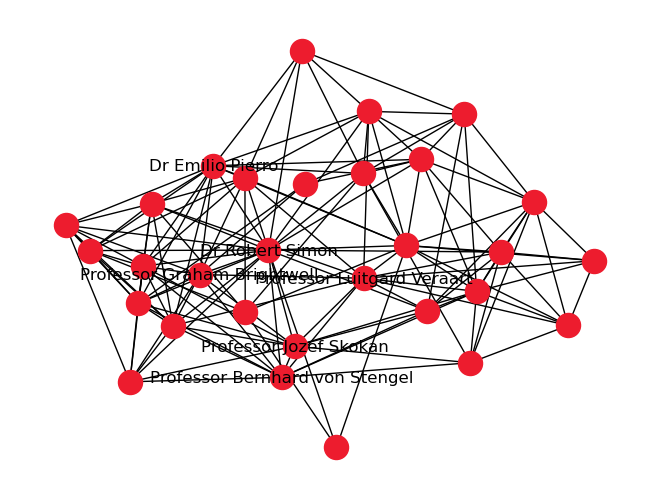

In [53]:
# Draw graph and add colouring
nx.draw(all_profs_graph, pos=pos, with_labels=False, node_color = LSE_RED)
# Add labels for top professors
nx.draw_networkx_labels(all_profs_graph,pos, labels, font_color='black');

## 4) A plot with nodes coloured and sized by eigenvector centrality

In [54]:
# Create labels for top 5 nodes in terms of eigenvetor centrality
labels = {}    
for node in all_profs_graph.nodes():
    if node in e_top10[:5]: 
        labels[node] = node

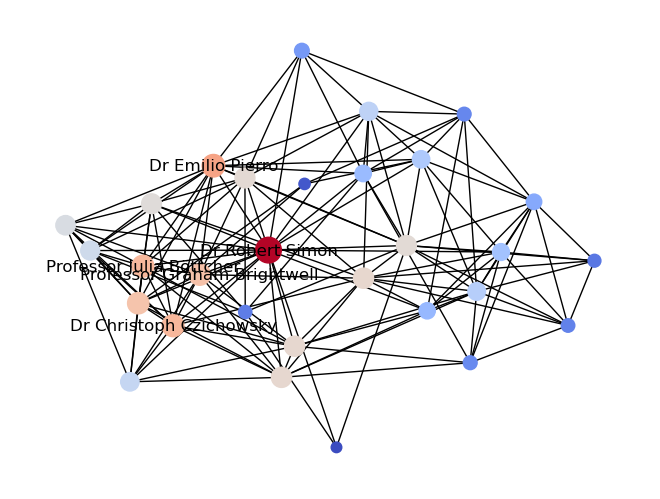

In [55]:
# Draw graph and add colouring
nx.draw(all_profs_graph, pos=pos, with_labels=False, \
        node_size = e_node_size*1000, \
        node_color = e_node_size, cmap=plt.cm.coolwarm)
# Add labels for top 5
nx.draw_networkx_labels(all_profs_graph,pos, labels, font_color='black');

# Conlusion:
- While the groups at first seem to be quite distinct, there is a lot of potential collaboration.
- 3 out of the 6 most important nodes belong to the `DMA` group.
- Very few nodes have have low degree (mean 10).
- Shortest paths between any two nodes are typially quite short. This is called the "Small-World Phenomenon".